# MODNet 'matbench_expt_gap' benchmarking

The `matbench_expt_gap` dataset contains measured band gaps for 4604 compositions of inorganic semiconductors from Zhuo *et al.*, JPCL.

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Markdown
from matminer.datasets import load_dataset, get_all_dataset_info
from pymatgen.core import Composition

from modnet.preprocessing import MODData
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = "5"


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



In [2]:
Markdown(filename="./README.md")

# matbench_expt_gap

## Introduction

- 4604 compositions and experimental band gaps

Results to beat:

| Method | Band gap (eV)
|:-------|-------|
| AM     | 0.416 | 
| RF     | 0.446 |
| Dummy  | 1.14  |

## Notes

- Extremely variable depending on validation set; probably high degree of bias in underlying data.
- Extremely well-behaved learning curves, consistently ~50 MPa on test set but double that on validation set.
- Errors are very long-tailed
- Should really consider doing feature importance with left-out data

## To-do

- [x] Featurize
- [x] Feature selection 
- [x] Baseline models
- [ ] Train best model
- [ ] Feature importance

## Results

| Method | Band gap (eV)
|:-------|-----------------:|
| Rough MODNet baseline     | 0.372


## Data exploration

In [3]:
df = load_dataset("matbench_expt_gap")
df["composition"] = df["composition"].map(Composition)

### Target space

In [4]:
df.describe()

,gap expt
count,4604.000000
mean,0.975951
std,1.445034
min,0.000000
25%,0.000000
50%,0.000000
75%,1.812500
max,11.700000


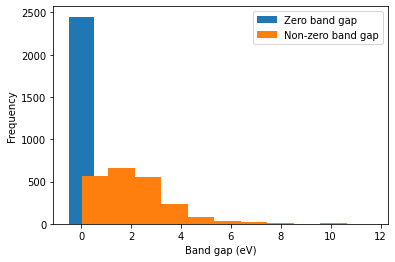

In [5]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df.where(df["gap expt"] == 0)["gap expt"], bins=1, density=False, label="Zero band gap")
ax.hist(df.where(df["gap expt"] > 0)["gap expt"], bins=11, density=False, label="Non-zero band gap")
ax.set_ylabel("Frequency")
ax.set_xlabel("Band gap (eV)")
ax.legend()

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [6]:
class CompositionOnlyFeaturizer(MODFeaturizer):
    composition_featurizers = DeBreuck2020Featurizer.composition_featurizers
    
    def featurize_composition(self, df):
        """ Applies the preset composition featurizers to the input dataframe,
        renames some fields and cleans the output dataframe.

        """
        from pymatgen.core.periodic_table import Element 
        import numpy as np
        from modnet.featurizers import clean_df
        df = super().featurize_composition(df)
        _orbitals = {"s": 1, "p": 2, "d": 3, "f": 4}
        df['AtomicOrbitals|HOMO_character'] = df['AtomicOrbitals|HOMO_character'].map(_orbitals)
        df['AtomicOrbitals|LUMO_character'] = df['AtomicOrbitals|LUMO_character'].map(_orbitals)

        df['AtomicOrbitals|HOMO_element'] = df['AtomicOrbitals|HOMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )
        df['AtomicOrbitals|LUMO_element'] = df['AtomicOrbitals|LUMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )

        df = df.replace([np.inf, -np.inf, np.nan], 0)
        
        return clean_df(df)

class CompositionContainer:
    def __init__(self, composition):
        self.composition = composition

In [7]:
PRECOMPUTED_MODDATA = "./precomputed/expt_gap_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_expt_gap")
    df["composition"] = df["composition"].map(Composition)
    df["structure"] = df["composition"].map(CompositionContainer)
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["gap expt"].tolist(), 
        target_names=["gap expt (eV)"],
        featurizer=CompositionOnlyFeaturizer(n_jobs=8)
    )
    data.featurize()
    data.feature_selection(n=-1)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f3f9456ed30> object, created with modnet version 0.1.8~develop


## Training

In [8]:
try:
    plot_benchmark
except:
    os.chdir("..")
    from modnet_matbench.utils import *
    
from sklearn.model_selection import KFold
from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

best_settings = {
    "num_neurons": [[64], [32], [8], [8]],
    "n_feat": 100,
    "lr": 0.005,
    "epochs": 1000,
    "verbose": 0,
    "act": "elu",
    "batch_size": 32,
    "loss": "mae",
}

results = matbench_benchmark(data, [[["E_g"]]], {"E_g": 1}, best_settings)

INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #1: MAE = 0.3523509228485965


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #2: MAE = 0.3705280060899504


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #3: MAE = 0.42130480466347825


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #4: MAE = 0.3495185636106907
Model #5: MAE = 0.36965937304431973
Overall MAE = 0.3726723340514071


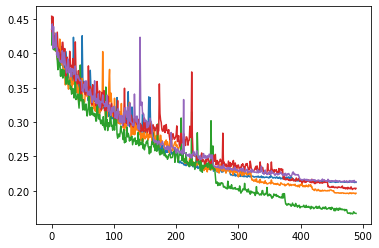

In [10]:
for i in range(5):
    plt.plot(results["models"][i].history.history["loss"][10:])

In [9]:
import seaborn as sns
reg_df = pd.DataFrame(
    np.array([
        [x for targ in results["targets"] for x in targ],
        [y for pred in results["predictions"] for y in pred],
        [e for err in results["errors"] for e in err]
    ]).T,
    columns=["targets", "predictions", "errors"]
)
splits = []
for i in range(5):
    for j in range(len(results["targets"][i])):
        splits.append(i)
reg_df["split"] = splits

Text(0, 0.5, 'Pred.')

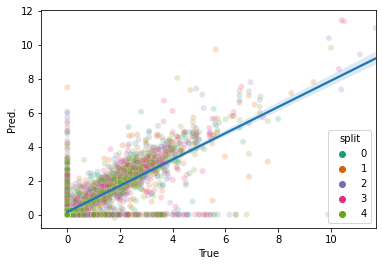

In [12]:
fig, ax = plt.subplots()
#ax.set_aspect("equal")
sns.scatterplot(data=reg_df, x="targets", y="predictions", hue="split", palette="Dark2", ax=ax, alpha=0.2)
sns.regplot(data=reg_df, x="targets", y="predictions", ax=ax, scatter=False)
# plt.plot(*ax.get_xlim(), *ax.get_xlim(), c="k",alpha=0.5)
ax.set_xlim(-1)
plt.xlabel("True")
plt.ylabel("Pred.")

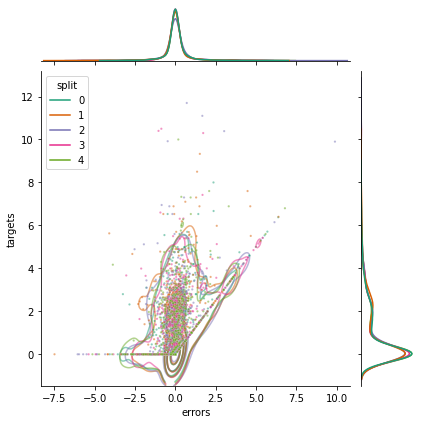

In [16]:
g = sns.jointplot(data=reg_df, x="errors", y="targets", hue="split", palette="Dark2", alpha=0.0, marginal_kws={"shade": False})
g.plot_joint(sns.scatterplot, hue=None, c="black", s=5, alpha=0.5)
g.plot_joint(sns.kdeplot, color="split", zorder=0, levels=5, alpha=0.5)